In [1]:
import sys
sys.path.append('..')

# OS and system
import os
import gc
import argparse
from argparse import Namespace
import pickle

# utils
from functools import partial
from copy import deepcopy
from tqdm import tqdm
import time

# mathematics
import matplotlib.pyplot as plt
import numpy as np
import random

# data handling
import pandas as pd

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# Torchvision
import torchvision

# logging
# import wandb

# my_lib
from model.net import *
from model.train import train, test
from misc.utils import save_checkpoint, load_transform, load_dataset


In [4]:
args = Namespace()

# args
args.data = 'cifair'
args.path_data = '../data/'
args.num_classes = 10
args.seed = 1
args.trainset_size = 500
args.validset_size = 10000
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# model
args.model = 'vcnn'
args.loss_type = 'ce'
args.class_dependent = 0

# dataset
args.split = 0
args.noise_rate = 0.0
args.noisy_valid = False

# seed reset
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed) # if use multi-GPU
random.seed(args.seed)
np.random.seed(args.seed)


In [5]:
transforms = load_transform(args)
train_dataset, valid_dataset, test_dataset = load_dataset(transforms, args)

print(len(train_dataset), len(valid_dataset), len(test_dataset))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
500 10000 10000


In [6]:
from torch.utils.data import RandomSampler

# dataloader
# args.batch_size = len(train_dataset) # full-batch gradient descent (GD)
args.batch_size = len(train_dataset)  # mini-batch gradient descent (SGD)
args.test_batch_size = 2048
args.num_workers = 4

# sampler = RandomSampler(train_dataset, replacement=True, num_samples=len(train_dataset))

# trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, sampler=sampler, num_workers=args.num_workers, pin_memory=True)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers, pin_memory=True)
print('torch train loader loaded.')
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=args.test_batch_size, shuffle=False, num_workers=args.num_workers, pin_memory=True)
print('torch valid loader loaded.')
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=False, num_workers=args.num_workers, pin_memory=True)
print('torch test loader loaded.')

torch train loader loaded.
torch valid loader loaded.
torch test loader loaded.


In [5]:
def hessian_vector_product(flat_grads, params, v):
    # Compute dot(grad, v)
    grad_v = torch.dot(flat_grads, v)
    second_grads = torch.autograd.grad(grad_v, params, retain_graph=True)
    return torch.cat([g.contiguous().view(-1) for g in second_grads])


def cal_hessian_trace(model, data_loader, device='cuda', num_samples=10):
    """
    Estimate the trace of the Hessian matrix using Hutchinson's method.
    
    Args:
        model: The neural network model.
        data_loader: DataLoader for the dataset.
        device: Device to perform computations ('cuda' or 'cpu').
        num_samples: Number of samples for Hutchinson's method.
    
    Returns:
        Estimated trace of the Hessian matrix.
    """
    model.eval()
    criterion = nn.CrossEntropyLoss(reduction='none')

    total_loss = 0.0
    for i, data in enumerate(data_loader):
        inputs, labels = data[0].to(args.device), data[1].to(args.device).long()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.sum()

    # Compute the total loss over the entire dataset
    total_loss = total_loss / len(data_loader.dataset)
    
    params = [p for p in model.parameters() if p.requires_grad]
    flat_params = torch.cat([p.view(-1) for p in params])

    # Compute first-order gradients
    grads = torch.autograd.grad(total_loss, params, create_graph=True)
    flat_grads = torch.cat([g.view(-1) for g in grads])

    trace_estimate = 0.0
    for _ in range(num_samples):
        # v ~ Rademacher distribution: ±1
        v = torch.randint_like(flat_params, low=0, high=2) * 2 - 1
        Hv = hessian_vector_product(flat_grads, params, v)
        trace_estimate += torch.dot(v, Hv).item()

    return trace_estimate / num_samples

In [10]:
class NoiseInjector:
    def __init__(self, model, args):
        self.device = args.device
        self.eps = args.perturb_eps
        self.perturb_type = args.perturb_type
        self.lr = args.lr
        
        self.std = self.eps * np.sqrt(self.lr) # Standard deviation for Gaussian noise
        
        self.param_shapes = [p.shape for p in model.parameters() if p.requires_grad]
        self.total_size = sum(p.numel() for p in model.parameters() if p.requires_grad)

        if args.perturb_type == 'anti':
            self.eps0 = args.perturb_eps0
            self.std = self.eps0 * np.sqrt(self.lr) # Standard deviation for Gaussian noise

            self.tau = args.perturb_tau
            self.anti_std = (self.eps/self.tau) * np.sqrt(self.lr)

            stationary_var = (self.eps ** 2 / self.tau) / (2 - self.lr / self.tau)
            self.anti_noise = torch.randn(self.total_size, device=self.device) * np.sqrt(stationary_var)
            self.anti_noise = self.anti_noise.to(self.device)

    def _update_anti_noise(self):
        with torch.no_grad():
            return (1 - (self.lr/self.tau)) * self.anti_noise + torch.randn(self.anti_noise.size()).to(self.device) * self.anti_std

    def generate_noise(self):
        if self.perturb_type == 'random':
            return torch.randn(self.total_size, device=self.device) * self.std
        elif self.perturb_type == 'anti':
            next_anti_noise = self._update_anti_noise()
            inj_noise = self.tau * (next_anti_noise - self.anti_noise) # add colored noise
            inj_noise += torch.randn(self.total_size, device=self.device) * self.std # add Gaussian noise
            self.anti_noise = next_anti_noise
            return inj_noise

    def apply_noise(self, model):
        inj_noise = self.generate_noise()

        offset = 0
        with torch.no_grad():
            for p in model.parameters():
                if p.requires_grad:
                    num = p.numel()
                    p.add_(inj_noise[offset:offset+num].view_as(p))
                    offset += num

In [8]:
# def initialize_v(model, device):
#     v_list = []
#     for m in model.modules():
#         if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
#             v_list.append(torch.zeros_like(m.weight).flatten())
#             if m.bias is not None:
#                 v_list.append(torch.zeros_like(m.bias).flatten())
#     return torch.cat(v_list).to(device)


# def perturb_model_(m, lr, eps, device):
#     with torch.no_grad():
#         if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#             # perturb the weights and biases of the layer
#             w_perturb = torch.randn(m.weight.size()).to(device)*(m.weight.norm(p=2)/np.sqrt(m.weight.flatten().size()[0])) * eps * torch.sqrt(lr)
#             m.weight.add_(w_perturb)
#             if m.bias is not None:
#                 b_perturb = torch.randn(m.bias.size()).to(device)*(m.bias.norm(p=2)/np.sqrt(m.bias.flatten().size()[0])) * eps * torch.sqrt(lr)
#                 m.bias.add_(b_perturb)


# def update_aoup_(v, lr, eps, tau, device):
#     with torch.no_grad():
#         # update the perturbation vector v_t
#         return (1 - (lr/tau)) * v + torch.randn(v.size()).to(device) * (eps/tau) * torch.sqrt(lr) * (v.norm(p=2)/np.sqrt(v.flatten().size()[0]))


# def anti_perturb_model_(m, v, lr, eps, tau, device):
#     with torch.no_grad():
#         if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#             # perturb the weights and biases of the layer
#             perturb_model_(m, lr, eps/2, device)

#             # add the anti-perturbation vector dv
#             v_next = update_aoup_(v, lr, eps/2, tau, device).to(device)
#             dv = v_next - v
#             m.weight.add_(tau * dv[0:m.weight.numel()].view(m.weight.size()))
#             if m.bias is not None:
#                 m.bias.add_(tau * dv[m.weight.numel():].view(m.bias.size()))

#             v.copy_(v_next)


def train(model, train_loader, optim, args, noise_injector = None, save_acc = False):
    """
        Train the model for one epoch.
        Args:
            model: the model to be trained
            train_loader: the dataloader for training data
            optim: the optimizer for the model
            args: the arguments for training
            perturb_model: a function to perturb the model (optional)
        Returns:
            train_log: a dictionary containing the training loss and accuracy (if save_acc is True)
    """
    train_log = {}
    train_log['loss'] = []
    train_log['acc'] = [] 

    model.train()
    for i, data in enumerate(train_loader):
        with torch.autograd.set_detect_anomaly(True):
            optim.zero_grad()

            inputs, labels = data[0].to(args.device), data[1].to(args.device).long()
            outputs = model(inputs)

            if args.loss_type == 'ce':
                criterion = nn.CrossEntropyLoss(reduction='none')
                loss = criterion(outputs, labels)
                loss = loss.mean()

            loss.backward()
            optim.step()

            # perturb the model
            if noise_injector is not None:
                if args.perturb_eps != 0:
                    noise_injector.apply_noise(model)

            # save the training accuracy
            if save_acc:
                # calculate acc.
                _, pred = torch.max(outputs.data, 1)
                correct = (pred == labels).sum()
                total = labels.size(0)
                acc = (100*correct/total).detach().cpu().numpy()
            else:
                acc = 0

            train_log['loss'].append(loss.detach().cpu().numpy())
            train_log['acc'].append(acc)
            
    return train_log


def test(model, test_loader, args):
    """
        Test the model on the test set.
        Args:
            model: the model to be tested
            test_loader: the dataloader for test data
            args: the arguments for testing
        Returns:
            test_log: a dictionary containing the test loss and accuracy
    """
    test_log = {}
    test_log['loss'] = []
    test_log['acc'] = []

    correct = 0
    total = 0
    loss = 0
    
    model.eval()
    criterion = nn.CrossEntropyLoss(reduction='none')
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            inputs, labels = data[0].to(args.device), data[1].to(args.device).long()
            outputs = model(inputs)
            
            # calculate acc.
            _, pred = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (pred == labels).sum()
            
            # calculate loss
            loss_ = criterion(outputs, labels)
            loss_ = loss_.sum()
            loss += loss_.detach().cpu().numpy()

    test_log['loss'].append(loss/len(test_loader.dataset))
    test_log['acc'].append((100*correct/total).detach().cpu().numpy())
                
    return test_log

In [ ]:
args.lr = 1e-2
args.momentum = 0.0
args.weight_decay = 0.0

args.perturb_eps0 = 0.0
args.perturb_eps = 0.01
args.perturb_type = 'anti' # 'random', 'anti'
args.perturb_tau = 1

curr_net, best_net = load_model(args)
curr_optimizer = optim.SGD(curr_net.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)

# perturb_func = partial(perturb_model_, lr=args.lr, eps=args.perturb_eps, device=args.device)
# anti_perturb_func = partial(anti_perturb_model_, lr=args.lr, eps=args.perturb_eps, tau=args.tau, device=args.device)

noise_injector = NoiseInjector(curr_net, args)

In [67]:
print(np.sum([torch.norm(p, 2).item() for p in curr_net.parameters()]))

noise_injector.apply_noise(curr_net)
print(np.sum([torch.norm(p, 2).item() for p in curr_net.parameters()]))

198.33652885258198
198.67182936519384


In [8]:
train_losses = []
test_losses = []
test_accs = []
# trace_hessians = []

for epoch in range(1, 2):
    print('Epoch:', epoch)
    train_log = train(curr_net, trainloader, curr_optimizer, args, noise_injector=None)
    # train_log = train(curr_net, trainloader, curr_optimizer, args, noise_injector=noise_injector)
    test_log = test(curr_net, testloader, args)

    test_log['epoch'] = [epoch]
    print(test_log)
    
    # trace_hessian = cal_hessian_trace(curr_net, trainloader, device=args.device, num_samples=10)
    print('Train Loss:', np.mean(train_log['loss']))
    print('Test Loss:', test_log['loss'][0], 'Test Acc:', test_log['acc'][0])
    # print('Trace Hessian:', trace_hessian)
    
    train_losses += train_log['loss']
    test_losses += test_log['loss']
    test_accs += test_log['acc']
    # trace_hessians.append(trace_hessian)
    

Epoch: 1


OutOfMemoryError: CUDA out of memory. Tried to allocate 626.00 MiB. GPU 0 has a total capacity of 11.99 GiB of which 0 bytes is free. Of the allocated memory 16.67 GiB is allocated by PyTorch, and 33.63 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

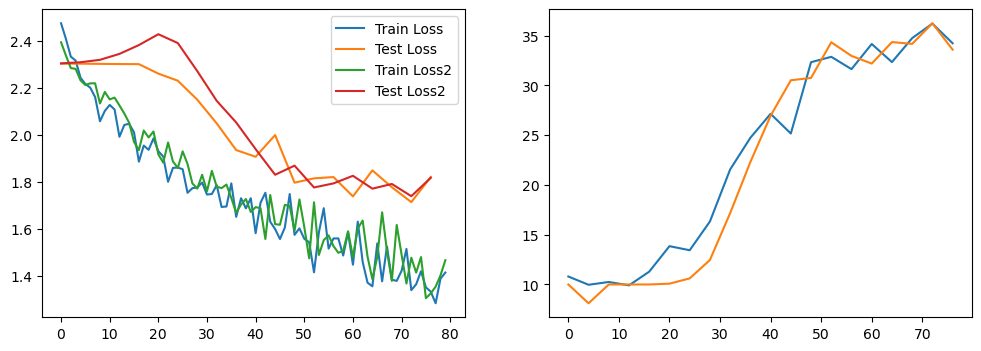

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

x_axis = np.arange(len(train_losses))

axs[0].plot(x_axis, train_losses, label='Train Loss')
axs[0].plot(x_axis[::4], test_losses, label='Test Loss')

axs[0].plot(x_axis, train_losses2, label='Train Loss2')
axs[0].plot(x_axis[::4], test_losses2, label='Test Loss2')

axs[0].legend()

axs[1].plot(x_axis[::4], test_accs, label='Test Accuracy')
axs[1].plot(x_axis[::4], test_accs2, label='Test Accuracy2')

In [14]:
train_losses2 = []
test_losses2 = []
test_accs2 = []
# trace_hessians = []

for epoch in range(1, 21):
    print('Epoch:', epoch)
    # train_log = train(curr_net, trainloader, curr_optimizer, args, noise_injector=None)
    train_log = train(curr_net, trainloader, curr_optimizer, args, noise_injector=noise_injector)
    test_log = test(curr_net, testloader, args)
    
    # trace_hessian = cal_hessian_trace(curr_net, trainloader, device=args.device, num_samples=10)
    print('Train Loss:', np.mean(train_log['loss']))
    print('Test Loss:', test_log['loss'][0], 'Test Acc:', test_log['acc'][0])
    # print('Trace Hessian:', trace_hessian)
    
    train_losses2 += train_log['loss']
    test_losses2 += test_log['loss']
    test_accs2 += test_log['acc']
    # trace_hessians.append(trace_hessian)
    

Epoch: 1
Train Loss: 2.3247995
Test Loss: 2.304812451171875 Test Acc: 10.0
Epoch: 2
Train Loss: 2.2212644
Test Loss: 2.30968701171875 Test Acc: 8.11
Epoch: 3
Train Loss: 2.157054
Test Loss: 2.3199966796875 Test Acc: 10.0
Epoch: 4
Train Loss: 2.0599687
Test Loss: 2.345136572265625 Test Acc: 10.0
Epoch: 5
Train Loss: 1.9898684
Test Loss: 2.382795703125 Test Acc: 10.0
Epoch: 6
Train Loss: 1.9137915
Test Loss: 2.428948681640625 Test Acc: 10.08
Epoch: 7
Train Loss: 1.8652221
Test Loss: 2.391296826171875 Test Acc: 10.61
Epoch: 8
Train Loss: 1.802671
Test Loss: 2.272026953125 Test Acc: 12.46
Epoch: 9
Train Loss: 1.7686284
Test Loss: 2.1453044921875 Test Acc: 17.17
Epoch: 10
Train Loss: 1.6934721
Test Loss: 2.053377099609375 Test Acc: 22.31
Epoch: 11
Train Loss: 1.6708964
Test Loss: 1.9398286865234375 Test Acc: 26.949999
Epoch: 12
Train Loss: 1.6598878
Test Loss: 1.8308361083984375 Test Acc: 30.519999
Epoch: 13
Train Loss: 1.6005541
Test Loss: 1.8696050537109374 Test Acc: 30.759998
Epoch: 14
T

In [ ]:
class NoiseInjector_test:
    def __init__(self, model, args):
        self.device = args.device
        self.eps = args.perturb_eps
        self.noise_type = args.noise_type
        self.lr = args.lr
        
        self.std = self.eps * np.sqrt(self.lr) # Standard deviation for Gaussian noise
        
        self.total_size = 2

        if args.noise_type == 'anti':
            self.tau = args.perturb_tau
            self.anti_std = (self.eps/self.tau) * np.sqrt(self.lr)

            self.stationary_var = (self.eps ** 2 / self.tau) / (2 - self.lr / self.tau)
            self.anti_noise = torch.randn(self.total_size, device=self.device) * np.sqrt(self.stationary_var)
            self.anti_noise = self.anti_noise.to(self.device)

    def _update_anti_noise(self):
        with torch.no_grad():
            return (1 - (self.lr/self.tau)) * self.anti_noise + torch.randn(self.anti_noise.size()).to(self.device) * self.anti_std

    def generate_noise(self):
        if self.noise_type == 'random':
            return torch.randn(self.total_size, device=self.device) * self.std
        elif self.noise_type == 'anti':
            next_anti_noise = self._update_anti_noise()
            # inj_noise = self.tau * (next_anti_noise - self.anti_noise) + torch.randn(self.total_size, device=self.device) * self.std
            inj_noise = self.tau * (next_anti_noise - self.anti_noise)
            self.anti_noise = next_anti_noise
            return inj_noise

    def apply_noise(self, model):
        inj_noise = self.generate_noise()

        offset = 0
        with torch.no_grad():
            for p in model.parameters():
                if p.requires_grad:
                    num = p.numel()
                    p.add_(inj_noise[offset:offset+num].view_as(p))
                    offset += num

In [214]:
args.lr = 0.5
args.perturb_eps = 1
args.perturb_tau = args.lr
args.noise_type = 'anti' # 'random', 'anti'

tmp = NoiseInjector_test(curr_net, args)

noises = np.array([tmp.generate_noise().detach().cpu().numpy() for i in range(10000)])

In [215]:
def autocorrelation(x, max_lag=None, normalize=True):
    n = len(x)
    x = x - np.mean(x)
    max_lag = n - 1 if max_lag is None else max_lag
    acf = np.array([
        np.correlate(x[:n - tau], x[tau:])[0] / (n - tau) for tau in range(max_lag + 1)
    ])
    if normalize:
        acf = acf  # Normalize by variance
    return acf

max_tau = 50
acf_vals = autocorrelation(noises[:, 0], max_lag=max_tau)

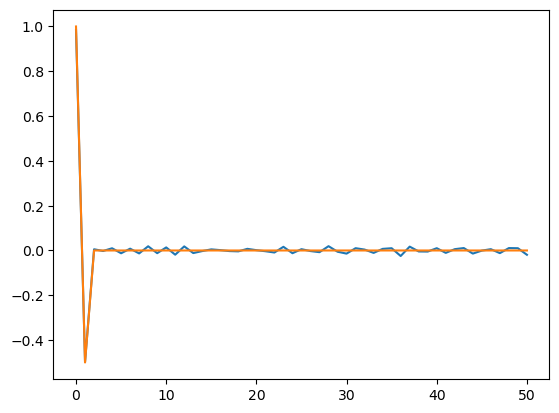

In [216]:
temp = 2 * args.perturb_eps**2 * args.lr

plt.plot(acf_vals)
plt.plot(np.arange(max_tau+1), [temp, -temp/2] + [0 for _ in range(max_tau-1)])


In [181]:
def autocorrelation(x, max_lag=None, normalize=True):
    n = len(x)
    x = x - np.mean(x)
    max_lag = n - 1 if max_lag is None else max_lag
    acf = np.array([
        np.mean(x[:n - tau] * x[tau:]) for tau in range(max_lag + 1)
    ])
    if normalize:
        acf = acf / acf[0]  # Normalize by variance
    return acf

max_tau = 10
acf_vals = autocorrelation(noises[:, 0], max_lag=max_tau)

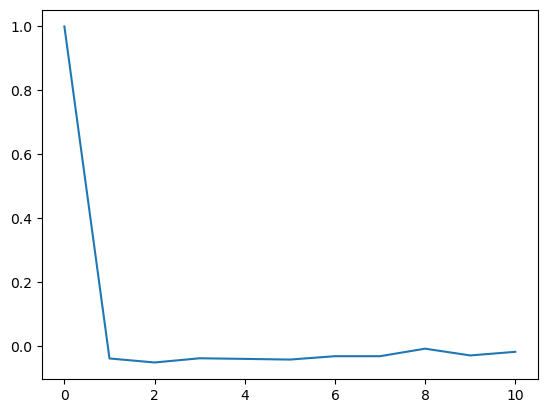

In [182]:
temp = (args.lr/args.tau) * (2-(args.lr/args.tau))

plt.plot(acf_vals)
# plt.plot(np.arange(0, max_tau+1), [1] + [-((args.lr/args.tau)**2) * (1-args.lr/args.perturb_tau)**(i) for i in range(1, max_tau+1)])


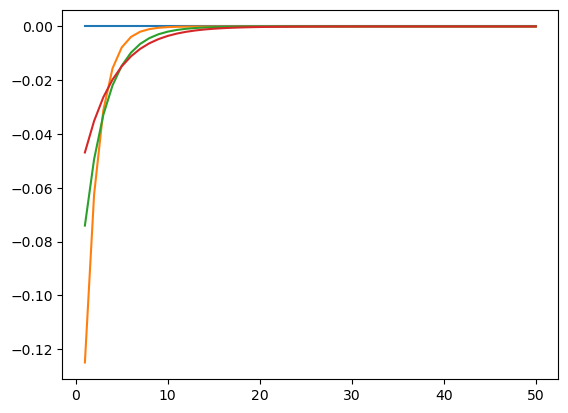

In [206]:
for t in range(1, 5):
    plt.plot(np.arange(1, max_tau+1), [-((args.lr/t)**2) * (1-args.lr/t)**(i) for i in range(1, max_tau+1)])


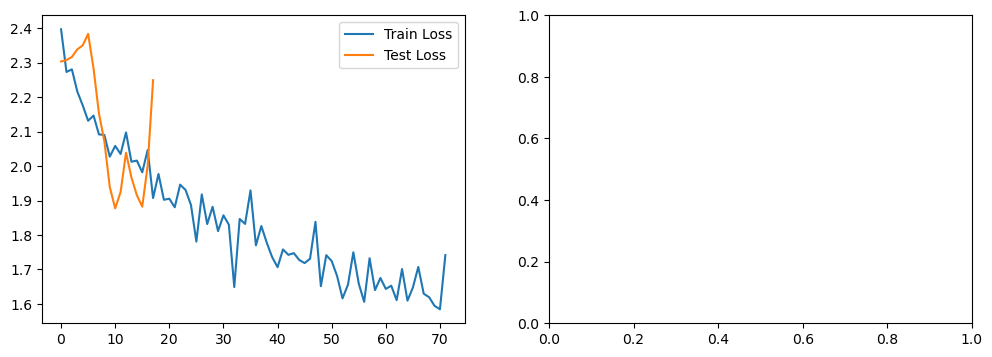

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(train_losses, label='Train Loss')
axs[0].plot(test_losses, label='Test Loss')

axs[0].legend()

In [ ]:
def compute_2_norm(model):
    norm = 0.0
    for param in model.parameters():
        norm += torch.norm(param, p=2).item() ** 2
    return norm ** 0.5

perturb_model = partial(perturb_model_, eps=args.perturb_eps, device=args.device)

network_2_norm = compute_2_norm(curr_net)
print("2-Norm of the network:", network_2_norm)
curr_net.apply(perturb_model)
perturb_2_norm = compute_2_norm(curr_net)
print("2-Norm of the perturbed network:", perturb_2_norm)


In [28]:
from torch.utils.data import RandomSampler

args.batch_size = 128
args.test_batch_size = 1024
args.num_workers = 4

sampler = RandomSampler(train_dataset, replacement=True, num_samples=len(train_dataset))

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, sampler=sampler, num_workers=args.num_workers, pin_memory=True)
print('torch train loader loaded.')
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=args.test_batch_size, shuffle=False, num_workers=args.num_workers, pin_memory=True)
print('torch valid loader loaded.')
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=False, num_workers=args.num_workers, pin_memory=True)
print('torch test loader loaded.')

torch train loader loaded.
torch valid loader loaded.
torch test loader loaded.


In [29]:
for epoch in range(1, 5):
    for data, target, _, _, _ in tqdm(trainloader):
        data, target = data.to(args.device), target.to(args.device).long()
        curr_optimizer.zero_grad()
        output = curr_net(data)
        loss = F.cross_entropy(output, target)

100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


In [32]:
for idx in tqdm(range(20)):
    train_1(curr_net, trainloader, curr_optimizer, args)

100%|██████████| 20/20 [03:11<00:00,  9.57s/it]


In [ ]:
iter(trainloader)

TypeError: 'int' object is not callable

In [34]:
import torch
from torch.utils.data import DataLoader, RandomSampler, TensorDataset

# Make a simple dummy dataset: 10 samples
data = torch.arange(50)  # [0, 1, 2, ..., 9]
labels = torch.arange(50)  # Just for formality

dataset = TensorDataset(data, labels)

# Create a RandomSampler with replacement
sampler = RandomSampler(dataset, replacement=True, num_samples=50)

# DataLoader using the sampler
loader = DataLoader(dataset, batch_size=10, sampler=sampler)

# Collect all sampled indices
sampled_indices = []

for batch_data, batch_labels in loader:
    print("Batch Data:", batch_data)
    sampled_indices.extend(batch_labels.tolist())  # Collect the label/index

print("Sampled Indices:", sampled_indices)

# Check if duplicates exist
duplicates_exist = len(sampled_indices) != len(set(sampled_indices))

print("Duplicates exist?", duplicates_exist)

Batch Data: tensor([33, 14,  8, 20, 39, 48, 13, 13, 17, 11])
Batch Data: tensor([23, 34, 37, 14, 13,  6, 41, 10, 40, 11])
Batch Data: tensor([ 7,  4,  2, 35, 30, 33, 39,  5, 35,  8])
Batch Data: tensor([29, 23, 28, 40, 14, 37,  9, 23, 10,  8])
Batch Data: tensor([32, 21, 32, 16, 22, 23, 42,  4,  5, 31])
Sampled Indices: [33, 14, 8, 20, 39, 48, 13, 13, 17, 11, 23, 34, 37, 14, 13, 6, 41, 10, 40, 11, 7, 4, 2, 35, 30, 33, 39, 5, 35, 8, 29, 23, 28, 40, 14, 37, 9, 23, 10, 8, 32, 21, 32, 16, 22, 23, 42, 4, 5, 31]
Duplicates exist? True


In [ ]:
# def hessian_trace_loss(loss, model, num_samples=1):
#     params = [p for p in model.parameters() if p.requires_grad]
#     flat_params = torch.cat([p.view(-1) for p in params])

#     # Compute first-order gradients
#     grads = torch.autograd.grad(loss, params, create_graph=True)
#     flat_grads = torch.cat([g.view(-1) for g in grads])

#     trace_estimate = 0.0
#     for _ in range(num_samples):
#         # v ~ Rademacher distribution: ±1
#         v = torch.randint_like(flat_params, low=0, high=2) * 2 - 1
#         Hv = hessian_vector_product(flat_grads, params, v)
#         trace_estimate += torch.dot(v, Hv).item()

#     return trace_estimate / num_samples

def hessian_vector_product(flat_grads, params, v):
    # Compute dot(grad, v)
    grad_v = torch.dot(flat_grads, v)
    second_grads = torch.autograd.grad(grad_v, params, retain_graph=True)
    return torch.cat([g.contiguous().view(-1) for g in second_grads])


def cal_hessian_trace(model, data_loader, device='cuda', num_samples=10):
    """
    Estimate the trace of the Hessian matrix using Hutchinson's method.
    
    Args:
        model: The neural network model.
        data_loader: DataLoader for the dataset.
        device: Device to perform computations ('cuda' or 'cpu').
        num_samples: Number of samples for Hutchinson's method.
    
    Returns:
        Estimated trace of the Hessian matrix.
    """
    model.eval()
    criterion = nn.CrossEntropyLoss(reduction='none')

    total_loss = 0.0
    for i, data in enumerate(data_loader):
        inputs, labels = data[0].to(args.device), data[1].to(args.device).long()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.sum()

    # Compute the total loss over the entire dataset
    print("Total loss:", total_loss)
    total_loss = total_loss / len(data_loader.dataset)
    
    params = [p for p in model.parameters() if p.requires_grad]
    flat_params = torch.cat([p.view(-1) for p in params])

    # Compute first-order gradients
    grads = torch.autograd.grad(total_loss, params, create_graph=True)
    flat_grads = torch.cat([g.view(-1) for g in grads])

    trace_estimate = 0.0
    for _ in range(num_samples):
        # v ~ Rademacher distribution: ±1
        v = torch.randint_like(flat_params, low=0, high=2) * 2 - 1
        Hv = hessian_vector_product(flat_grads, params, v)
        trace_estimate += torch.dot(v, Hv).item()

    return trace_estimate / num_samples


In [125]:
hessian_trace(curr_net, trainloader, device=args.device, num_samples=10)

Total loss: tensor(991.3391, device='cuda:0', grad_fn=<AddBackward0>)


18441.66318359375

In [136]:
import pandas as pd

In [ ]:
train_losses = np.array(train_losses)

array([2.375978 , 2.3263574, 2.2703838, 2.2433445, 2.2314353, 2.22051  ,
       2.231141 , 2.18674  , 2.091715 , 2.1019928, 2.0846071, 2.1244626,
       2.037027 , 1.970298 , 2.0751536, 2.0324283, 1.9767723, 1.9201167,
       1.9392891, 2.0197687, 1.9189138, 1.9116201, 1.8724055, 1.9426538,
       1.8786275, 1.8455395, 1.8787649, 1.9117005, 1.8725166, 1.8122324,
       1.8064167, 1.7758642, 1.7608258, 1.7506541, 1.7244725, 1.802722 ,
       1.7307887, 1.7396336, 1.6616614, 1.8411194, 1.6644465, 1.7025416,
       1.7019308, 1.6982054, 1.6299539, 1.7337363, 1.615294 , 1.6918243,
       1.5869341, 1.6523162, 1.6460404, 1.6943296, 1.7093141, 1.5455196,
       1.6116385, 1.5746458, 1.5921956, 1.5368676, 1.5485489, 1.6210872,
       1.4631965, 1.5908461, 1.5493379, 1.5169795, 1.490879 , 1.4952278,
       1.4926162, 1.4616133, 1.4654875, 1.3943545, 1.5099791, 1.5308877],
      dtype=float32)

In [151]:
tmp = {}
tmp['train_loss'] = train_losses
tmp['test_loss'] = train_losses

tmp2 = {}
tmp2['train_loss'] = train_losses
tmp2['test_loss'] = train_losses

In [152]:
train_df = pd.DataFrame([tmp, tmp2])

train_df

,train_loss,test_loss
0,"[2.375978, 2.3263574, 2.2703838, 2.2433445, 2....","[2.375978, 2.3263574, 2.2703838, 2.2433445, 2...."
1,"[2.375978, 2.3263574, 2.2703838, 2.2433445, 2....","[2.375978, 2.3263574, 2.2703838, 2.2433445, 2...."


In [153]:
train_df['train_loss']

0    [2.375978, 2.3263574, 2.2703838, 2.2433445, 2....
1    [2.375978, 2.3263574, 2.2703838, 2.2433445, 2....
Name: train_loss, dtype: object

In [156]:
np.arange(1, 1 + 1)


array([1])